In [1]:
import os
import glob
import pickle
from IPython.display import Markdown
from config import datapath

import pandas as pd
import numpy as np
import datetime as dt

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline

today = "22042024"

with open(datapath + f'/ema_data_{today}.pkl', 'rb') as file:
    df_active = pickle.load(file)

with open(datapath + f'/gps_data_{today}.pkl', 'rb') as file:
    df_gps = pickle.load(file)
    
with open(datapath + f'/passive_data_{today}.pkl', 'rb') as file:
    df_passive = pickle.load(file)

with open(datapath + f'/monitoring_data_{today}.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

In [2]:
df_gps_merged = df_gps.merge(df_monitoring, on = "customer", how="inner")

In [3]:
df_gps_merged = df_gps_merged.loc[df_gps_merged.status == "Abgeschlossen"]

In [4]:
df_int = df_gps.pivot_table(
    index=["customer", "startTimestamp"],
    columns="type",
    values=["doubleValue", "startTimestamp_hour", "startTimestamp_day"],
    aggfunc='first'  # Using 'first' since each type should theoretically have only one entry per customer and timestamp
)

# Flatten the MultiIndex in columns
df_int.columns = ['_'.join(col).strip() for col in df_int.columns.values]

df_int = df_int.rename_axis(None, axis=1).reset_index()

# Drop redundant day and hour columns for longitude (assuming latitude day and hour are kept)
df_int = df_int.drop(columns=[
    'startTimestamp_day_Longitude',
    'startTimestamp_hour_Longitude'
])

# Rename the columns for clarity
df_int = df_int.rename(columns={
    'doubleValue_Latitude': 'Latitude',
    'doubleValue_Longitude': 'Longitude',
    'startTimestamp_day_Latitude': 'Day',  # Keeping one 'Day' column
    'startTimestamp_hour_Latitude': 'Hour'  # Keeping one 'Hour' column
})

df_int['weekday'] = df_int['Day'].dt.day_name()
df_int["n_hours"] = df_int.groupby(["customer", "Day"])["Hour"].transform("nunique")
df_int["n_data"] = df_int.groupby("customer")["Longitude"].transform("size")
df_int["n_data_day"] = df_int.groupby(["customer", "Day"])["Longitude"].transform("size")

df_int = df_int.loc[df_int["n_hours"] >= 8]
df_int["n_days_8"] = df_int.groupby("customer")["Day"].transform("nunique")
df_int = df_int.loc[df_int["n_days_8"] >= 50]

# Ensure your DataFrame is sorted by customer and day
df_int = df_int.sort_values(by=['customer', 'Day'])


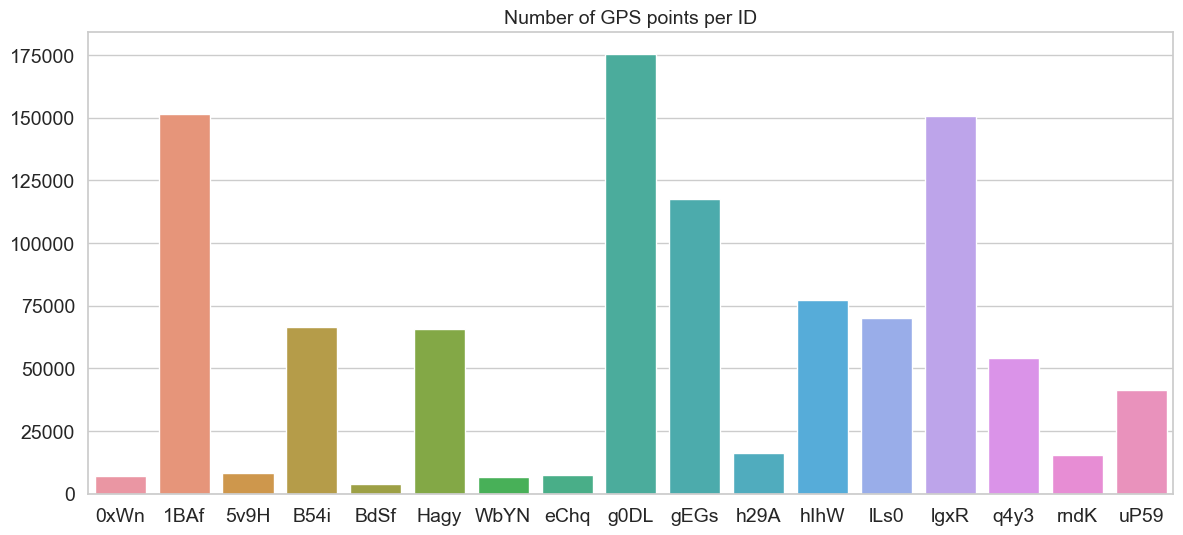

In [6]:
plt.figure(figsize=(14, 6))
sns.barplot(x='customer', y='n_data', data=df_int)
plt.title('Number of GPS points per ID',fontsize=14)
plt.ylabel('')
plt.xlabel('')


#plt.savefig("barplot_high_quality.png", dpi=300, format='png', bbox_inches='tight')
# Showing the plot
plt.show()

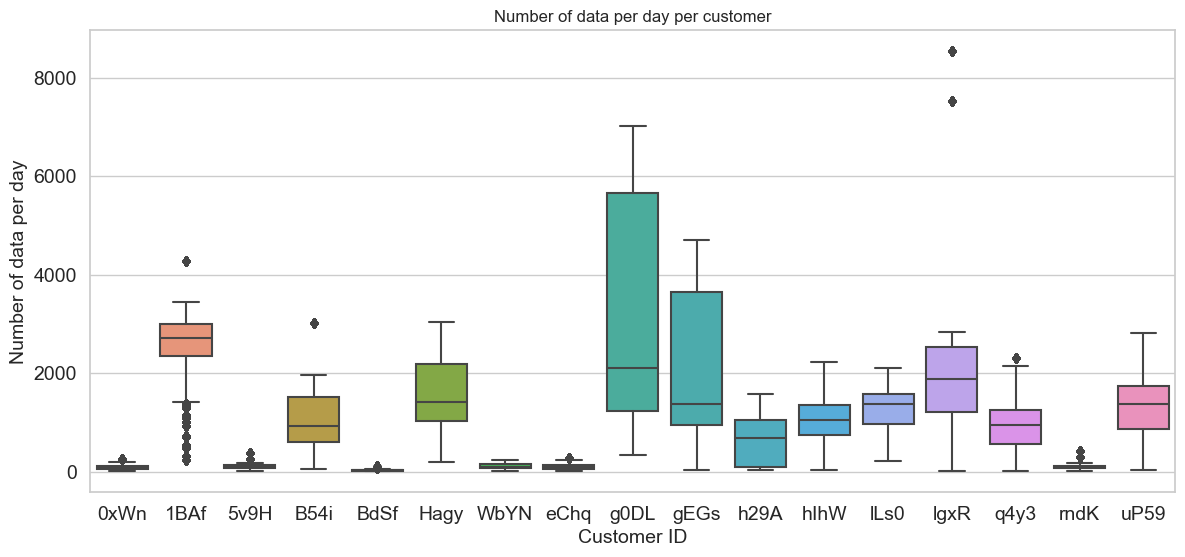

In [7]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='customer', y='n_data_day', data=df_int)
plt.title('Number of data per day per customer')
plt.ylabel('Number of data per day')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

In [8]:
df_single1 = df_int.loc[df_int.customer == "Hagy"]
df_single2 = df_int.loc[df_int.customer == "WbYN"]

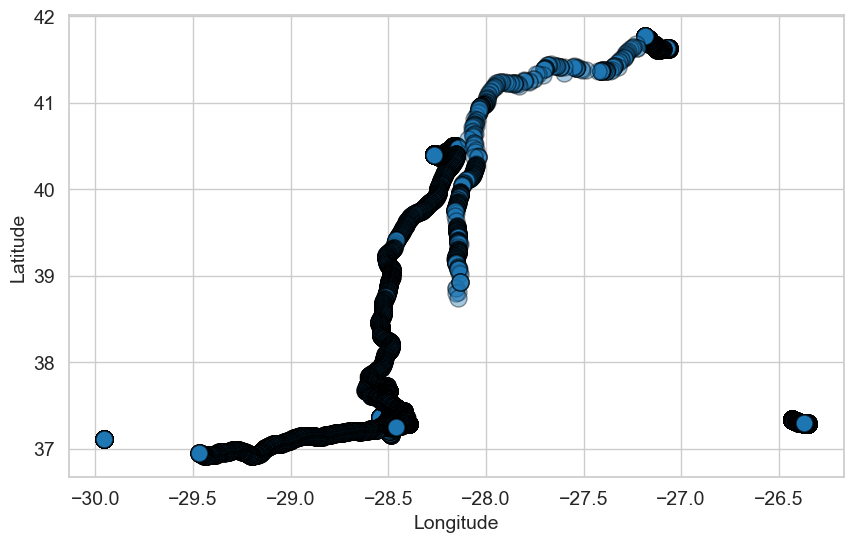

In [9]:
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single1['Longitude'], df_single1['Latitude'],edgecolor= "k", alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.savefig('i0t0_raw.png', dpi=300)

plt.show()

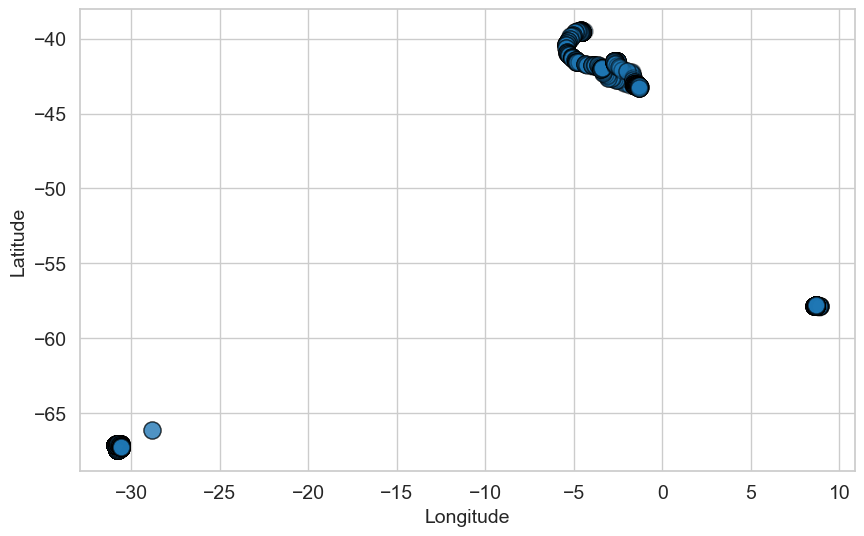

In [10]:
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single2['Longitude'], df_single2['Latitude'],edgecolor= "k", alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.savefig('i0t0_raw.png', dpi=300)

plt.show()

In [11]:
# Haversine formula to calculate distance between two lat/lon points in meters
def haversine(lon1, lat1, lon2, lat2):
    R = 6371000  # Radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    meters = R * c  # Output distance in meters
    return meters

In [13]:
max_distance = 150  # Example value, adjust as needed

# Initializing columns to store calculated values
df_speed['distance'] = np.nan
df_speed['time_diff'] = np.nan
df_speed['speed'] = np.nan

# Calculating distance, time difference, and speed for each customer independently
for customer in df_speed['customer'].unique():
    mask = df_speed['customer'] == customer
    
    df_speed.loc[mask, 'distance'] = np.concatenate([
        haversine(
            df_speed.loc[mask, 'Longitude'].values[:-1], df_speed.loc[mask, 'Latitude'].values[:-1],
            df_speed.loc[mask, 'Longitude'].values[1:], df_speed.loc[mask, 'Latitude'].values[1:]
        ),
        [0]
    ])
    
    df_speed.loc[mask, 'time_diff'] = df_speed.loc[mask, 'startTimestamp'].diff().dt.total_seconds().fillna(0)
    
    # Avoid division by zero and replace NaN if time_diff is 0
    df_speed.loc[mask, 'speed'] = df_speed.loc[mask, 'distance'] / df_speed.loc[mask, 'time_diff'].replace(0, np.nan)

# Filtering condition
speed_limit = 1.4  # Max allowed speed in m/s

# Creating the stationary DataFrame
stationary_df = df_speed[(df_speed['speed'] < speed_limit) & (df_speed['distance'] < max_distance)]

In [14]:
df_single3 = stationary_df.loc[stationary_df.customer == "Hagy"]
df_single4 = stationary_df.loc[stationary_df.customer == "WbYN"]

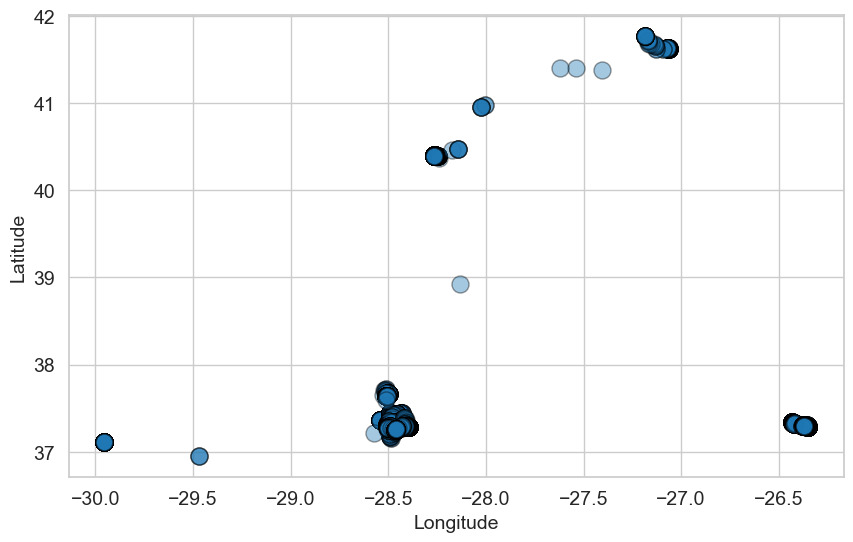

In [15]:
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single3['Longitude'], df_single3['Latitude'],edgecolor= "k", alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.savefig('i0t0_raw.png', dpi=300)

plt.show()

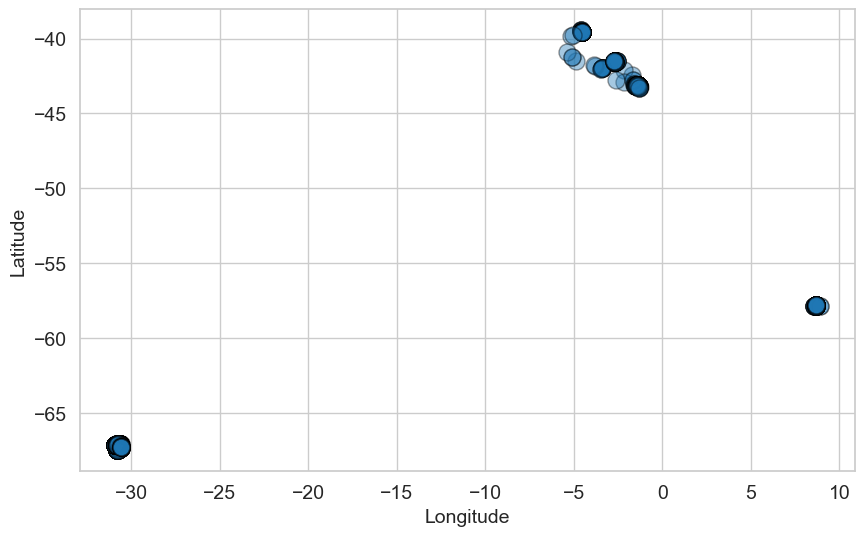

In [16]:
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single4['Longitude'], df_single4['Latitude'],edgecolor= "k", alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.savefig('i0t0_raw.png', dpi=300)

plt.show()